In [16]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit

In [17]:
# define functions
def LinearFunc(t, a, b):
    return a * t + b

def AiryFunc(t, B, A, F, T, t0):
    return B + A / ( 1 + F * (np.sin( (np.pi/T)*(t-t0) ))**2 )

def ChiSqrd(Data, Fit, Error):
    return sum( (Data - Fit)**2 ) / (Error**2)

def RdChiSqrd(Data, Fit, Error, NumPrams):
    return sum( (Data - Fit)**2 ) / (Error**2 * (np.size(Data) - NumPrams - 2))

def Cali(t, t0, DriveSlope, FPDriveSlope, FP_Period):
    return ( (DriveSlope * 10) / (FPDriveSlope*FP_Period) )*(t - t0)

def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

## Calibration with the Fabry-Perot 1

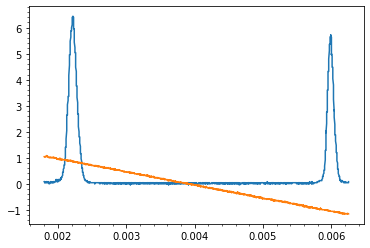



Error in the voltage for the Fabry-Perot = (+/-) 0.020478307755054048 V


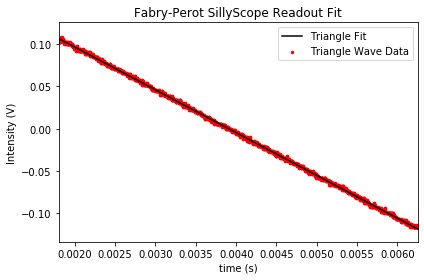

In [18]:
# Importing and formatting data
# Reading Files
ramp0 = pd.read_csv("New Data/Calibration (Widest)/A0032CH1.CSV")
FP0 = pd.read_csv("New Data/Calibration (Widest)/A0032CH2.CSV")

#Seperating Data
RawRampTime = pd.DataFrame(ramp0, columns= ['col 1'])
RawRamp = pd.DataFrame(ramp0, columns= ['col 2'])
RawFPTime = pd.DataFrame(FP0, columns= ['col 1'])
RawFP = pd.DataFrame(FP0, columns= ['col 2'])

#Formatting Data
RampTime = np.resize(RawRampTime,(4000,1))
Ramp = np.resize(RawRamp,(4000,1))
FabryTime = np.resize(RawFPTime,(4000,1))
Fabry = np.resize(RawFP,(4000,1))

t_start = 0.0018
t_end = 0.00625

#pulling out important indices
j = 0
for i in FabryTime: 
    if i == t_start:
        t1 = j
    if i == t_end:
        t2 = j
    if i == 0.0027:
        tf1 = j
    if i == 0.0055:
        tf2 = j
    j += 1

#Resizing and cutting
BackgroundT_pts = FabryTime[tf1:tf2,0]
BackgroundFabry = Fabry[tf1:tf2,0]

RampTime = RampTime[t1:t2,0]
Ramp = Ramp[t1:t2,0]
FabryTime = FabryTime[t1:t2,0]
Fabry = Fabry[t1:t2,0]

#DoubleChecking Times
TimeDiff = RampTime - FabryTime

for i in TimeDiff:
    if i != 0:
        print("ERROR")
        
t_pts = FabryTime

plt.plot(t_pts, Fabry)
plt.plot(t_pts, Ramp*(10))
#plt.plot(BackgroundT_pts, BackgroundFabry)
plt.minorticks_on()
plt.show()



# Fitting and plotting the Triangle Wave
TriGuess = [-0.06, 6.4]
TriParam, TriParam_cov = curve_fit(LinearFunc, t_pts, Ramp, TriGuess, maxfev=150000)

########################################################
FPTriSlope1 = TriParam[0]
FPTriSlope_Err1 = np.sqrt(TriParam_cov[0,0])
########################################################

print("")
#Tri_RCS = RdChiSqrd(Fabry, AiryFunc(t_pts, *FPParam), FPV_error, 5)
#print("Reduced Chi Squared = " + str(FP_RCS))

fig = plt.figure()
FPplt = fig.add_subplot(1,1,1)
FPplt.scatter(t_pts, Ramp, label='Triangle Wave Data', color='red', s=6)
FPplt.plot(t_pts, LinearFunc(t_pts, *TriParam), label='Triangle Fit', color='black')
#FPplt.errorbar(t_pts, Fabry, color='red', yerr= FPV_error, capsize= 3)
FPplt.set_xlim(t_start,t_end)
#FPplt.set_xlim(-2,12)
FPplt.set_xlabel("time (s)")
FPplt.set_ylabel('Intensity (V)')
FPplt.set_title('Fabry-Perot SillyScope Readout Fit')
FPplt.legend();

fig.tight_layout()



# Finding the error for our fit
BackgroundGuess = [0, 0.02]

BackParam, BackParam_cov = curve_fit(LinearFunc, BackgroundT_pts, BackgroundFabry, BackgroundGuess, maxfev=150000)

FPV_error = np.sqrt( sum( (BackgroundFabry - LinearFunc(BackgroundT_pts, *BackParam))**2 ) / (np.size(BackgroundT_pts) - 2) )
FPV_errorArray = FPV_error * np.linspace(1,1,np.size(t_pts))
print("")
print("Error in the voltage for the Fabry-Perot = (+/-) " + str(FPV_error) + " V")


index 0 = -0.057733425024948964 +/- 0.006112601857593265
index 1 = 6.397591186499927 +/- 0.039800003795294255
index 2 = 550.9051571754346 +/- 10.35723055993203
index 3 = 0.0037712480828737092 +/- 6.360550554642151e-07
index 4 = 0.0022162486963091224 +/- 4.497310172885512e-07

Chi Squared = 336189.1609859879
Reduced Chi Squared = 151.5731113552696


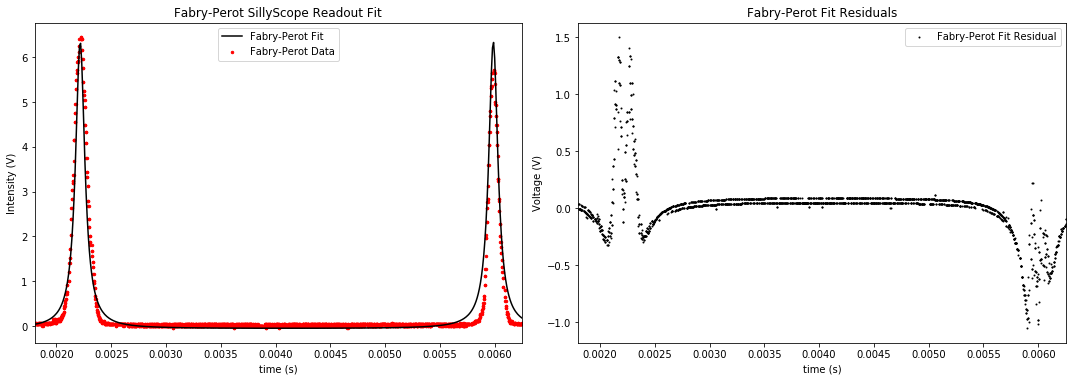

In [19]:
# Fitting and plotting the Fabry-Perot

FPGuess = [0, 6, 550, .00377, .0022]
#AiryFuncPrams (Zero, Amplitude, Finness, Period, First Peak Position)
FPParam, FPParam_cov = curve_fit(AiryFunc, t_pts, Fabry, FPGuess, sigma= FPV_errorArray, maxfev=150000)

#print("0: Background") print("1: Amplitude") print("2: Finness") print("3: Period") print("4: t0")
print("")

i = 0
while i < 5:
    print("index " + str(i) + " = " + str(FPParam[i]) + " +/- " + str(np.sqrt(FPParam_cov[i,i])) )
    i += 1

########################################################    
FP_Period1 = FPParam[3]
FP_Period_Err1 = np.sqrt(FPParam_cov[3,3])
########################################################

print("")
FP_RCS = RdChiSqrd(Fabry, AiryFunc(t_pts, *FPParam), FPV_error, 5)
FP_CS = ChiSqrd(Fabry, AiryFunc(t_pts, *FPParam), FPV_error)

print("Chi Squared = " + str(FP_CS))
print("Reduced Chi Squared = " + str(FP_RCS))

fig = plt.figure(figsize=(15,10))
FPplt = fig.add_subplot(2,2,1)
#FPplt.scatter(RelativeFreq, Fabry, label='Fabry-Perot Data', color='red', s=6)
FPplt.scatter(t_pts, Fabry, label='Fabry-Perot Data', color='red', s=6)
FPplt.plot(t_pts, AiryFunc(t_pts, *FPParam), label='Fabry-Perot Fit', color='black')
#FPplt.errorbar(t_pts, Fabry, color='red', yerr= FPV_error, capsize= 3)
FPplt.set_xlim(t_start,t_end)
#FPplt.set_xlim(-2,12)
FPplt.set_xlabel("time (s)")
FPplt.set_ylabel('Intensity (V)')
FPplt.set_title('Fabry-Perot SillyScope Readout Fit')
FPplt.legend();

FPResidplt = fig.add_subplot(2,2,2)
FPResidplt.scatter(t_pts, (Fabry - AiryFunc(t_pts, *FPParam)), label='Fabry-Perot Fit Residual', color='black', s=1)
FPResidplt.set_xlim(t_start,t_end)
FPResidplt.set_xlabel("time (s)")
FPResidplt.set_ylabel('Voltage (V)')
FPResidplt.set_title('Fabry-Perot Fit Residuals')
FPResidplt.legend();

fig.tight_layout()

## Calibration with the Fabry-Perot 2

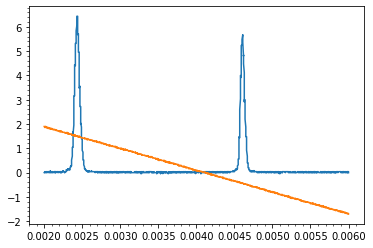



Error in the voltage for the Fabry-Perot = (+/-) 0.02104132139177564 V


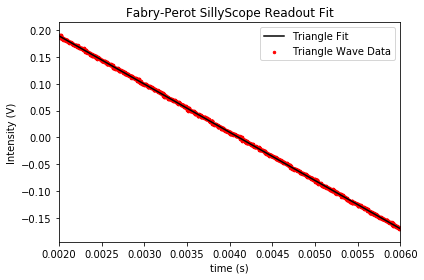

In [20]:
# Importing and formatting data
# Reading Files
ramp0 = pd.read_csv("New Data/Calibration/A0030CH1.CSV")
FP0 = pd.read_csv("New Data/Calibration/A0030CH2.CSV")

#Seperating Data
RawRampTime = pd.DataFrame(ramp0, columns= ['col 1'])
RawRamp = pd.DataFrame(ramp0, columns= ['col 2'])
RawFPTime = pd.DataFrame(FP0, columns= ['col 1'])
RawFP = pd.DataFrame(FP0, columns= ['col 2'])

#Formatting Data
RampTime = np.resize(RawRampTime,(4000,1))
Ramp = np.resize(RawRamp,(4000,1))
FabryTime = np.resize(RawFPTime,(4000,1))
Fabry = np.resize(RawFP,(4000,1))

t_start = 0.002
t_end = 0.006
t_start_back = 0.003
t_end_back = 0.004

#pulling out important indices
j = 0
for i in FabryTime: 
    if i == t_start:
        t1 = j
    if i == t_end:
        t2 = j
    if i == t_start_back:
        tf1 = j
    if i == t_end_back:
        tf2 = j
    j += 1

#Resizing and cutting
BackgroundT_pts = FabryTime[tf1:tf2,0]
BackgroundFabry = Fabry[tf1:tf2,0]

RampTime = RampTime[t1:t2,0]
Ramp = Ramp[t1:t2,0]
FabryTime = FabryTime[t1:t2,0]
Fabry = Fabry[t1:t2,0]

#DoubleChecking Times
TimeDiff = RampTime - FabryTime

for i in TimeDiff:
    if i != 0:
        print("ERROR")
        
t_pts = FabryTime

plt.plot(t_pts, Fabry)
plt.plot(t_pts, Ramp*(10))
#plt.plot(BackgroundT_pts, BackgroundFabry)
plt.minorticks_on()
plt.show()



# Fitting and plotting the Triangle Wave
TriGuess = [-0.06, 6.4]
TriParam, TriParam_cov = curve_fit(LinearFunc, t_pts, Ramp, TriGuess, maxfev=150000)

########################################################
FPTriSlope2 = TriParam[0]
FPTriSlope_Err2 = np.sqrt(TriParam_cov[0,0])
########################################################

print("")
#Tri_RCS = RdChiSqrd(Fabry, AiryFunc(t_pts, *FPParam), FPV_error, 5)
#print("Reduced Chi Squared = " + str(FP_RCS))

fig = plt.figure()
FPplt = fig.add_subplot(1,1,1)
FPplt.scatter(t_pts, Ramp, label='Triangle Wave Data', color='red', s=6)
FPplt.plot(t_pts, LinearFunc(t_pts, *TriParam), label='Triangle Fit', color='black')
#FPplt.errorbar(t_pts, Fabry, color='red', yerr= FPV_error, capsize= 3)
FPplt.set_xlim(t_start,t_end)
#FPplt.set_xlim(-2,12)
FPplt.set_xlabel("time (s)")
FPplt.set_ylabel('Intensity (V)')
FPplt.set_title('Fabry-Perot SillyScope Readout Fit')
FPplt.legend();

fig.tight_layout()



# Finding the error for our fit
BackgroundGuess = [0, 0.02]

BackParam, BackParam_cov = curve_fit(LinearFunc, BackgroundT_pts, BackgroundFabry, BackgroundGuess, maxfev=150000)

FPV_error = np.sqrt( sum( (BackgroundFabry - LinearFunc(BackgroundT_pts, *BackParam))**2 ) / (np.size(BackgroundT_pts) - 2) )
FPV_errorArray = FPV_error * np.linspace(1,1,np.size(t_pts))
print("")
print("Error in the voltage for the Fabry-Perot = (+/-) " + str(FPV_error) + " V")



Reduced Chi Squared = 86.53234795312602


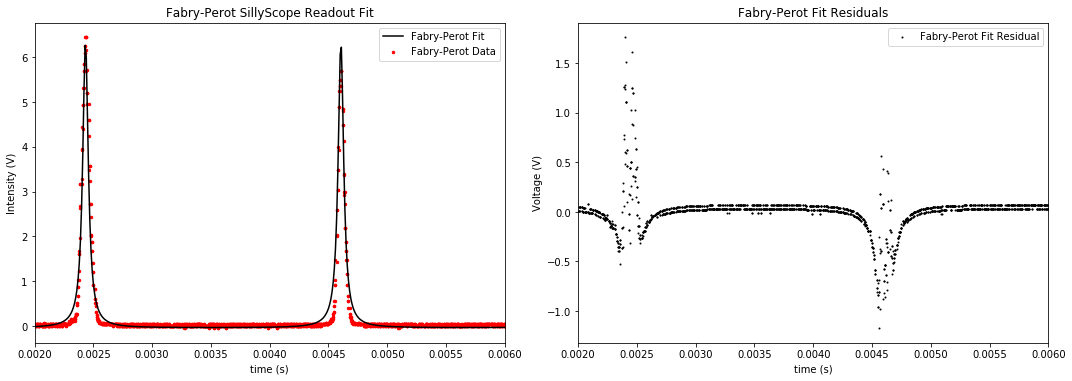

In [21]:
# Fitting and plotting the Fabry-Perot

FPGuess = [0, 6, 550, .0022, .0024]
#AiryFuncPrams (Zero, Amplitude, Finness, Period, First Peak Position)
FPParam, FPParam_cov = curve_fit(AiryFunc, t_pts, Fabry, FPGuess, sigma= FPV_errorArray, maxfev=150000)

#print("0: Background") print("1: Amplitude") print("2: Finness") print("3: Period") print("4: t0")
print("")

#i = 0
#while i < 5:
#    print("index " + str(i) + " = " + str(FPParam[i]) + " +/- " + str(np.sqrt(FPParam_cov[i,i])) )
#    i += 1
    
########################################################    
FP_Period2 = FPParam[3]
FP_Period_Err2 = np.sqrt(FPParam_cov[3,3])
########################################################

print("")
FP_RCS = RdChiSqrd(Fabry, AiryFunc(t_pts, *FPParam), FPV_error, 5)
#FP_CS = ChiSqrd(Fabry, AiryFunc(t_pts, *FPParam), FPV_error)
print("Reduced Chi Squared = " + str(FP_RCS))

fig = plt.figure(figsize=(15,10))
FPplt = fig.add_subplot(2,2,1)
#FPplt.scatter(RelativeFreq, Fabry, label='Fabry-Perot Data', color='red', s=6)
FPplt.scatter(t_pts, Fabry, label='Fabry-Perot Data', color='red', s=6)
FPplt.plot(t_pts, AiryFunc(t_pts, *FPParam), label='Fabry-Perot Fit', color='black')
#FPplt.errorbar(t_pts, Fabry, color='red', yerr= FPV_error, capsize= 3)
FPplt.set_xlim(t_start,t_end)
#FPplt.set_xlim(-2,12)
FPplt.set_xlabel("time (s)")
FPplt.set_ylabel('Intensity (V)')
FPplt.set_title('Fabry-Perot SillyScope Readout Fit')
FPplt.legend();

FPResidplt = fig.add_subplot(2,2,2)
FPResidplt.scatter(t_pts, (Fabry - AiryFunc(t_pts, *FPParam)), label='Fabry-Perot Fit Residual', color='black', s=1)
FPResidplt.set_xlim(t_start,t_end)
FPResidplt.set_xlabel("time (s)")
FPResidplt.set_ylabel('Voltage (V)')
FPResidplt.set_title('Fabry-Perot Fit Residuals')
FPResidplt.legend();

fig.tight_layout()

In [29]:
#FP_Period1
#FPTriSlope1

#FP_Period_Err1
#FPTriSlope_Err1

Muliplier1 = 1/(FP_Period1*FPTriSlope1)
Muliplier2 = 1/(FP_Period2*FPTriSlope2)

Muliplier1_Var = (FP_Period_Err1/(FP_Period1**2 * FPTriSlope1))**2 + (FPTriSlope_Err1/(FP_Period1 * FPTriSlope1**2))**2
Muliplier2_Var = (FP_Period_Err2/(FP_Period2**2 * FPTriSlope2))**2 + (FPTriSlope_Err2/(FP_Period2 * FPTriSlope2**2))**2

Muliplier_Avg = ((Muliplier1/Muliplier1_Var) + (Muliplier2/Muliplier2_Var)) / ((1/Muliplier1_Var) + (1/Muliplier2_Var))
Muliplier_Avg_Err = 1/( (1/Muliplier1_Var) + (1/Muliplier2_Var) )

print(Muliplier_Avg)
print(Muliplier_Avg_Err)

-5.169066740202884
1.8472146461547026e-06
